# Dicionário de Dados

O dicionário de dados utilizado nessa analise é o dicionário disponível no link abaixo. Ele contém as definições da maioria das variáveis.

[Fonte](https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/SRAG/pdfs/Dicionario_de_Dados_SRAG_Hospitalizado_19.09.2022.pdf)

# 1. Carregamento da Base

In [1371]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score,
    precision_score, recall_score, f1_score
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
# Lendo a base
dados = pd.read_csv('INFLUD23-24-03-2025.csv', sep=';', encoding='latin1', low_memory=False)

# Visualizando as primeiras linhas
dados.shape
dados.head()


,DT_NOTIFIC,SEM_NOT,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,ID_REGIONA,CO_REGIONA,ID_MUNICIP,CO_MUN_NOT,ID_UNIDADE,CO_UNI_NOT,CS_SEXO,DT_NASC,NU_IDADE_N,TP_IDADE,COD_IDADE,CS_GESTANT,CS_RACA,CS_ESCOL_N,ID_PAIS,CO_PAIS,SG_UF,ID_RG_RESI,CO_RG_RESI,ID_MN_RESI,CO_MUN_RES,CS_ZONA,SURTO_SG,NOSOCOMIAL,AVE_SUINO,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,OUTRO_SIN,OUTRO_DES,PUERPERA,FATOR_RISC,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,NEUROLOGIC,PNEUMOPATI,IMUNODEPRE,RENAL,OBESIDADE,OBES_IMC,OUT_MORBI,MORB_DESC,VACINA,DT_UT_DOSE,MAE_VAC,DT_VAC_MAE,M_AMAMENTA,DT_DOSEUNI,DT_1_DOSE,DT_2_DOSE,ANTIVIRAL,TP_ANTIVIR,OUT_ANTIV,DT_ANTIVIR,HOSPITAL,DT_INTERNA,SG_UF_INTE,ID_RG_INTE,CO_RG_INTE,ID_MN_INTE,CO_MU_INTE,UTI,DT_ENTUTI,DT_SAIDUTI,SUPORT_VEN,RAIOX_RES,RAIOX_OUT,DT_RAIOX,AMOSTRA,DT_COLETA,TP_AMOSTRA,OUT_AMOST,PCR_RESUL,DT_PCR,POS_PCRFLU,TP_FLU_PCR,PCR_FLUASU,FLUASU_OUT,PCR_FLUBLI,FLUBLI_OUT,POS_PCROUT,PCR_VSR,PCR_PARA1,PCR_PARA2,PCR_PARA3,PCR_PARA4,PCR_ADENO,PCR_METAP,PCR_BOCA,PCR_RINO,PCR_OUTRO,DS_PCR_OUT,CLASSI_FIN,CLASSI_OUT,CRITERIO,EVOLUCAO,DT_EVOLUCA,DT_ENCERRA,DT_DIGITA,HISTO_VGM,PAIS_VGM,CO_PS_VGM,LO_PS_VGM,DT_VGM,DT_RT_VGM,PCR_SARS2,PAC_COCBO,PAC_DSCBO,OUT_ANIM,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA,TOMO_RES,TOMO_OUT,DT_TOMO,TP_TES_AN,DT_RES_AN,RES_AN,POS_AN_FLU,TP_FLU_AN,POS_AN_OUT,AN_SARS2,AN_VSR,AN_PARA1,AN_PARA2,AN_PARA3,AN_ADENO,AN_OUTRO,DS_AN_OUT,TP_AM_SOR,SOR_OUT,DT_CO_SOR,TP_SOR,OUT_SOR,DT_RES,RES_IGG,RES_IGM,RES_IGA,ESTRANG,VACINA_COV,DOSE_1_COV,DOSE_2_COV,DOSE_REF,FAB_COV_1,FAB_COV_2,FAB_COVREF,LAB_PR_COV,LOTE_1_COV,LOTE_2_COV,LOTE_REF,FNT_IN_COV,DOSE_2REF,FAB_COVRF2,LOTE_REF2,TRAT_COV,TIPO_TRAT,OUT_TRAT,DT_TRT_COV,CO_DETEC,VG_OMS,VG_OMSOUT,VG_LIN,VG_MET,VG_METOUT,VG_DTRES,VG_ENC,VG_REINF,REINF,FAB_ADIC,LOT_RE_BI,FAB_RE_BI,DOSE_ADIC,DOS_RE_BI,LOTE_ADIC,TABAG
0,21/01/2023,3,20/01/2023,3,MG,DIAMANTINA,1450.0,ARACUAI,310340,HOSPITAL SAO VICENTE DE PAULO ARACUAI,2134276,F,04/05/1940,82,3,3082,9,1.0,1,BRASIL,1,MG,DIAMANTINA,1450,ARACUAI,310340.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,NaN,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1.0,21/01/2023,MG,DIAMANTINA,1450,ARACUAI,310340,2.0,NaN,NaN,NaN,6,NaN,NaN,1.0,21/01/2023,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,2,1,27/01/2023,27/01/2023,25/01/2023,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,NaN,NaN,NaN,2,21/01/2023,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,08/02/2023,6,23/01/2023,4,RS,014 CRS,1602.0,CAMPINA DAS MISSOES,430370,POSTO DE SAUDE SEDE E PACS CAMPINA DAS MISSOES,2250225,M,01/07/1941,81,3,3081,6,1.0,1,BRASIL,1,RS,014 CRS,1602,CAMPINA DAS MISSOES,430370.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,NaN,NaN,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,NaN,1.0,CA PROSTATA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,01/02/2023,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,2.0,5,ESPESSAMENTO DE PAREDES BRONQU,01/02/2023,1.0,08/02/2023,1.0,NaN,1.0,10/02/2023,2.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,1,3,02/03/2023,02/03/2023,08/02/2023,0.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,16/03/2021,13/04/2021,28/10/2021,86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC,86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC,87 - COVID-19 PFIZER - COMIRNATY,86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC,210051,210132,FG3531,2.0,07/06/2022,85 - COVID-19 ASTRAZENECA/FIOCRUZ - COVISHIELD,21OVCD316Z,9.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14/02/2023,7,13/02/2023,7,SC,FLORIANOPOLIS,1476.0,FLORIANOPOLIS,420540,INSTITUTO DE ENSINO E PESQUISA DR IRINEU

In [1372]:
# Tamanho da base
print(f"Total de registros: {dados.shape[0]}")
print(f"Total de colunas: {dados.shape[1]}")

Total de registros: 278976
Total de colunas: 190


## 2. Filtragem Inicial

In [1373]:
# Valores únicos presentes na variável resposta
valores_unicos = dados['EVOLUCAO'].unique()
print("Valores únicos em 'EVOLUCAO':", valores_unicos)

# Porcentagem de valores ausentes
porcentagem_nulo = dados['EVOLUCAO'].isnull().mean() * 100
print(f"\nPorcentagem de valores nulos em 'EVOLUCAO': {porcentagem_nulo:.2f}%")


Valores únicos em 'EVOLUCAO': ['1' '3' nan '9' '2' '15/' '10/' '20/']

Porcentagem de valores nulos em 'EVOLUCAO': 4.96%


In [1374]:
# Definindo valores inválidos para remover
valores_invalidos = ['3', '9', '10/', '15/', '20/']

# Filtrando a base
dados_filtrados = dados[
    (dados['EVOLUCAO'].isin(['1', '2']))  # mantém só 1 e 2
].copy()

# Convertendo para inteiro para facilitar uso posterior
dados_filtrados['EVOLUCAO'] = dados_filtrados['EVOLUCAO'].astype(int)

# Exibindo forma final da base
print(f"Shape original: {dados.shape}")
print(f"Shape após remoção de nulos e inválidos: {dados_filtrados.shape}")

# Verificando distribuição dos valores restantes
print("\nDistribuição de EVOLUCAO:")
print(dados_filtrados['EVOLUCAO'].value_counts(normalize=True))


Shape original: (278976, 190)
Shape após remoção de nulos e inválidos: (250820, 190)

Distribuição de EVOLUCAO:
EVOLUCAO
1    0.900482
2    0.099518
Name: proportion, dtype: float64


## 3. Remoção de Colunas com Muitos Valores Ausentes

In [1375]:
# Verifica a porcentagem de valores nulos por coluna
porcentagem_nulo = dados_filtrados.isnull().mean() * 100

# Exibe a porcentagem de nulos (opcional)
print("Porcentagem de valores nulos por coluna:")
print(porcentagem_nulo)

# Remove as colunas com mais de 90% de valores nulos
dados_filtrados = dados_filtrados.loc[:, porcentagem_nulo < 90]

# Exibe as colunas removidas (opcional)
colunas_removidas = porcentagem_nulo[porcentagem_nulo >= 90].index.tolist()
print("\nColunas removidas (>= 90% nulos):")
print(colunas_removidas)

Porcentagem de valores nulos por coluna:
DT_NOTIFIC      0.000000
SEM_NOT         0.000000
DT_SIN_PRI      0.000000
SEM_PRI         0.000000
SG_UF_NOT       0.000000
ID_REGIONA     12.690376
CO_REGIONA     12.690376
ID_MUNICIP      0.000000
CO_MUN_NOT      0.000000
ID_UNIDADE      0.000000
CO_UNI_NOT      0.000000
CS_SEXO         0.000000
DT_NASC         0.029503
NU_IDADE_N      0.000000
TP_IDADE        0.000000
COD_IDADE       0.000000
CS_GESTANT      0.000000
CS_RACA         0.000000
CS_ESCOL_N     35.519097
ID_PAIS         0.000000
CO_PAIS         0.000000
SG_UF           0.023124
ID_RG_RESI     11.589586
CO_RG_RESI     11.589586
ID_MN_RESI      0.023124
CO_MUN_RES      0.023124
CS_ZONA         7.587114
SURTO_SG       36.363926
NOSOCOMIAL     10.628339
AVE_SUINO      14.423491
FEBRE          13.512878
TOSSE           8.455865
GARGANTA       27.316004
DISPNEIA       13.003349
DESC_RESP      15.521490
SATURACAO      17.737023
DIARREIA       27.863009
VOMITO         27.054461
OUTRO_SIN

## 4. Remoção de Colunas Irrelevantes

In [1376]:
# Lista consolidada das colunas a remover (alta taxa de nulos + descrições livres)
colunas_para_remover = [
    'DT_TOMO', 'POS_AN_FLU', 'POS_AN_OUT', 'MORB_DESC', 'OUTRO_DES',
    'POS_PCROUT', 'POS_PCRFLU', 'LOTE_REF2', 'FAB_COVRF2', 'DOSE_2REF',
    'DT_SAIDUTI', 'DS_AN_OUT', 'DS_PCR_OUT', 'HISTO_VGM'
]

# Remoção das colunas, se existirem
dados_filtrados = dados_filtrados.drop(columns=[col for col in colunas_para_remover if col in dados_filtrados.columns])


In [1377]:
colunas_administrativas_remover = [
    'SEM_NOT', 'SEM_PRI', 'SG_UF_NOT', 'ID_REGIONA', 'CO_REGIONA',
    'CO_MUN_NOT', 'ID_UNIDADE', 'CO_UNI_NOT', 'ID_PAIS', 'CO_PAIS',
    'ID_RG_RESI', 'CO_RG_RESI', 'ID_MN_RESI', 'CO_MUN_RES',
    'SG_UF_INTE', 'ID_RG_INTE', 'CO_RG_INTE', 'ID_MN_INTE', 'CO_MU_INTE',
    'DT_DIGITA', 'ID_MUNICIP', 'TP_IDADE', 'COD_IDADE'
]

# Remover colunas administrativas da base final
dados_filtrados = dados_filtrados.drop(columns=[col for col in colunas_administrativas_remover if col in dados_filtrados.columns])


In [1378]:
colunas_dt_remover = [
    'DT_EVOLUCA', 'DT_RAIOX', 'DT_RES_AN', 'DT_PCR',
    'DT_COLETA', 'DT_ENCERRA', 'DT_NASC'
]

dados_filtrados = dados_filtrados.drop(columns=[col for col in colunas_dt_remover if col in dados_filtrados.columns])


## 5. Conversão de Datas Importantes e Geração de Flags

In [1379]:
# Datas úteis
colunas_dt_util = ['DT_SIN_PRI', 'DT_NOTIFIC', 'DT_INTERNA', 'DT_ENTUTI']

# Converter para datetime
for col in colunas_dt_util:
    dados_filtrados[col] = pd.to_datetime(dados_filtrados[col], errors='coerce', dayfirst=True)

# Flags binárias
dados_filtrados['FOI_INTERNADO'] = dados_filtrados['DT_INTERNA'].notnull().astype(int)
dados_filtrados['ENTROU_UTI'] = dados_filtrados['DT_ENTUTI'].notnull().astype(int)

# Remover colunas de data que viraram flags
colunas_para_remover = ['DT_INTERNA', 'DT_ENTUTI']
dados_filtrados = dados_filtrados.drop(columns=[col for col in colunas_para_remover if col in dados_filtrados.columns])


In [1380]:
# Lista de colunas a remover (irrelevantes + opcionais)
colunas_para_remover = [
    # Colunas irrelevantes
    'LOTE_1_COV', 'LOTE_2_COV', 'LOTE_REF',
    'FAB_COV_1', 'FAB_COV_2', 'FAB_COVREF',
    'LAB_PR_COV', 'CO_DETEC', 'SURTO_SG', 'DOSE_REF', 'DOSE_2_COV', 'DOSE_1_COV' ,
    'TP_TES_AN', 'TP_AMOSTRA', 'ESTRANG'
]

# Remover colunas do DataFrame
dados_filtrados = dados_filtrados.drop(columns=[col for col in colunas_para_remover if col in dados_filtrados.columns])



## 6. Ajustes de Lógica para Variáveis Dependentes do Sexo

In [1381]:
# Homens → valor 6 (não se aplica)
dados_filtrados.loc[dados_filtrados['CS_SEXO'] == 'M', 'CS_GESTANT'] = 6

# Mulheres com valor ausente → valor 9 (ignorado)
dados_filtrados.loc[
    (dados_filtrados['CS_SEXO'] == 'F') & (dados_filtrados['CS_GESTANT'].isnull()),
    'CS_GESTANT'
] = 9


In [1382]:
# Todos os homens são marcados como "não puérpera" (2)
dados_filtrados.loc[dados_filtrados['CS_SEXO'] == 'M', 'PUERPERA'] = 2

# Mulheres com valor ausente → marcar como "ignorado" (9)
dados_filtrados.loc[
    (dados_filtrados['CS_SEXO'] == 'F') & (dados_filtrados['PUERPERA'].isnull()),
    'PUERPERA'
] = 9


## 7. Imputação de Valores Faltantes com 9

In [1383]:
# Lista geral de colunas com NaN a serem imputadas com 9 (exceto datas e variáveis de tempo)
colunas_a_imputar = [
    'PUERPERA', 'OBESIDADE', 'HEPATICA', 'SIND_DOWN', 'HEMATOLOGI',
    'RENAL', 'IMUNODEPRE', 'DOSE_REF', 'PNEUMOPATI', 'NEUROLOGIC',
    'ASMA', 'DIABETES', 'OUT_MORBI', 'CARDIOPATI', 'DOSE_2_COV',
    'DOSE_1_COV', 'VACINA', 'TOMO_RES', 'CS_ESCOL_N', 'RAIOX_RES',
    'PERD_PALA', 'PERD_OLFT', 'OUTRO_SIN', 'DOR_ABD', 'DIARREIA',
    'GARGANTA', 'VOMITO', 'FADIGA', 'TRAT_COV', 'ANTIVIRAL',
    'SATURACAO', 'DESC_RESP', 'AVE_SUINO', 'FEBRE', 'DISPNEIA',
    'SUPORT_VEN', 'UTI', 'NOSOCOMIAL', 'RES_AN', 'TOSSE',
    'PCR_RESUL', 'CS_ZONA', 'CRITERIO', 'REINF', 'CLASSI_FIN',
    'HOSPITAL', 'AMOSTRA', 'SG_UF', 'VACINA_COV', 'FNT_IN_COV'
]

for col in colunas_a_imputar:
    if col in dados_filtrados.columns:
        dados_filtrados[col] = dados_filtrados[col].fillna(9)



In [1384]:
# Calculando porcentagem de nulos
porcentagem_nulos = dados_filtrados.isnull().mean() * 100

# Organizando em ordem alfabética
porcentagem_nulos_ordenado = porcentagem_nulos.sort_values(ascending=False)

# Exibindo como lista formatada
for coluna, porcentagem in porcentagem_nulos_ordenado.items():
    print(f"{coluna}: {porcentagem:.2f}% de valores faltantes")


DT_NOTIFIC: 0.00% de valores faltantes
DT_SIN_PRI: 0.00% de valores faltantes
CS_SEXO: 0.00% de valores faltantes
NU_IDADE_N: 0.00% de valores faltantes
CS_GESTANT: 0.00% de valores faltantes
CS_RACA: 0.00% de valores faltantes
CS_ESCOL_N: 0.00% de valores faltantes
SG_UF: 0.00% de valores faltantes
CS_ZONA: 0.00% de valores faltantes
NOSOCOMIAL: 0.00% de valores faltantes
AVE_SUINO: 0.00% de valores faltantes
FEBRE: 0.00% de valores faltantes
TOSSE: 0.00% de valores faltantes
GARGANTA: 0.00% de valores faltantes
DISPNEIA: 0.00% de valores faltantes
DESC_RESP: 0.00% de valores faltantes
SATURACAO: 0.00% de valores faltantes
DIARREIA: 0.00% de valores faltantes
VOMITO: 0.00% de valores faltantes
OUTRO_SIN: 0.00% de valores faltantes
PUERPERA: 0.00% de valores faltantes
FATOR_RISC: 0.00% de valores faltantes
CARDIOPATI: 0.00% de valores faltantes
HEMATOLOGI: 0.00% de valores faltantes
SIND_DOWN: 0.00% de valores faltantes
HEPATICA: 0.00% de valores faltantes
ASMA: 0.00% de valores faltan

## 8. Conversão de Tipos e Limpeza Fina

In [1385]:
# converter colunas float64 para int
for col in dados_filtrados.columns:
    if dados_filtrados[col].dtype == 'float64':
        dados_filtrados[col] = dados_filtrados[col].astype('Int64')



In [1386]:

# Remover registros com idade negativa
dados_filtrados = dados_filtrados[dados_filtrados['NU_IDADE_N'] >= 0].copy()

# Corrigir valor 0 em CS_GESTANT → substituir por 9 (ignorado)
dados_filtrados.loc[dados_filtrados['CS_GESTANT'] == 0, 'CS_GESTANT'] = 9

# Remover registros com SG_UF = '9'
dados_filtrados = dados_filtrados[dados_filtrados['SG_UF'] != '9'].copy()


In [1387]:
# Função para verificar tipos únicos em cada coluna
def encontrar_colunas_mistas(df):
    colunas_mistas = {}

    for col in df.columns:
        tipos = df[col].map(type).nunique()
        if tipos > 1:
            colunas_mistas[col] = df[col].map(type).value_counts()

    return colunas_mistas

# Aplicando a função no seu DataFrame
colunas_com_dados_mistos = encontrar_colunas_mistas(dados_filtrados)

# Exibindo os resultados
for coluna, tipos in colunas_com_dados_mistos.items():
    print(f"\nColuna: {coluna}")
    print(tipos)



Coluna: CS_ESCOL_N
CS_ESCOL_N
<class 'str'>    161730
<class 'int'>     89088
Name: count, dtype: int64

Coluna: SG_UF
SG_UF
<class 'str'>    250760
<class 'int'>        58
Name: count, dtype: int64

Coluna: RAIOX_RES
RAIOX_RES
<class 'str'>    168189
<class 'int'>     82629
Name: count, dtype: int64

Coluna: CRITERIO
CRITERIO
<class 'str'>    245090
<class 'int'>      5728
Name: count, dtype: int64


In [1388]:
# Lista das colunas que você quer converter para int
colunas_para_int = ['CS_ESCOL_N', 'RAIOX_RES', 'CRITERIO']

# Converter para int, tratando possíveis valores não convertíveis
for col in colunas_para_int:
    dados_filtrados[col] = pd.to_numeric(dados_filtrados[col], errors='coerce').astype('Int64')  # Usa tipo nulo-friendly

# Garantir que SG_UF está como string
dados_filtrados['SG_UF'] = dados_filtrados['SG_UF'].astype(str)



# Documentação de Código - Tratamento e Pré-processamento da Base SRAG 2023

Aqui está descrito todas as etapas de tratamento e pré-processamento aplicadas aos dados da base de internações por Síndrome Respiratória Aguda Grave (SRAG) de 2023 acima, visando garantir transparência, reprodutibilidade e compreensão total do pipeline de limpeza dos dados. Todas as etapas foram realizadas levando em consideração o dicionário de dados disponível no link acima.

## 1. Carregamento da Base
- **Leitura da base**: Arquivo `INFLUD23-24-03-2025.csv`, separado por `;`, codificação `latin1`.
- **Visualização inicial**: Verificação de dimensões e das primeiras linhas.
- **Análise da variável resposta (`EVOLUCAO`)**:
  - Identifica valores exclusivos presentes.
  - Calcula a porcentagem de valores nulos.

## 2. Filtragem Inicial
- Mantidos apenas os registros com `EVOLUCAO` igual a 1 ou 2 (óbito ou cura).
- Conversão da variável `EVOLUCAO` para inteiro para facilitar modelagem posterior.

## 3. Remoção de Colunas com Muitos Valores Ausentes
- Cálculo da porcentagem de valores ausentes por coluna.
- Remoção de colunas com 90% ou mais de dados nulos.
- Lista das colunas removidas.

## 4. Remoção de Colunas Irrelevantes
- **Colunas descritivas livres e redundantes**: como `MORB_DESC`, `OUTRO_DES`, entre outras.
- **Colunas administrativas**: como `SG_UF_NOT`, `CO_MUN_NOT`, `ID_REGIONA`, entre outras.
- **Colunas de datas que não são informativas**: como `DT_NASC`, `DT_EVOLUCA`, `DT_RAIOX`, etc.
- **Colunas sobre vacinação, lote, fabricante e outras consideradas não essenciais**.

## 5. Conversão de Datas Importantes e Geração de Flags
- Colunas de data relevantes (`DT_SIN_PRI`, `DT_NOTIFIC`, `DT_INTERNA`, `DT_ENTUTI`) foram convertidas para `datetime`.
- Foram criadas duas variáveis binárias:
  - `FOI_INTERNADO`: 1 se `DT_INTERNA` não é nula.
  - `ENTROU_UTI`: 1 se `DT_ENTUTI` não é nula.
- As datas usadas nessas flags foram então removidas.

## 6. Ajustes de Lógica para Variáveis Dependentes do Sexo
- Homens (CS_SEXO = 'M') recebem:
  - `CS_GESTANT = 6` (não se aplica)
  - `PUERPERA = 2` (não puérpera)
- Mulheres com valores ausentes nessas variáveis recebem valor 9 (ignorado).

## 7. Imputação de Valores Faltantes com 9
- Criada uma lista de variáveis categóricas e booleanas.
- Valores ausentes nestas variáveis foram imputados com 9, representando "ignorado" conforme padrão da base.

## 8. Conversão de Tipos e Limpeza Fina
- Conversão de colunas numéricas `float64` para `Int64`, preservando `NaN`.
- Remoção de registros com:
  - Idade negativa (`NU_IDADE_N < 0`)
  - `SG_UF = '9'` (ignorado)
  - `CS_GESTANT = 0` (substituído por 9)
- Verificação de colunas com tipos mistos usando uma função auxiliar.
- Conversão para `Int64` nas colunas problemáticas (`CS_ESCOL_N`, `RAIOX_RES`, `CRITERIO`).
- Conversão de `SG_UF` para string para evitar problemas futuros com merge e visualização.

---


## Analise Exploratória

In [1389]:
# Garante melhor visualização dos gráficos
sns.set(style="whitegrid")

# Converter datas para datetime
dados_filtrados['DT_NOTIFIC'] = pd.to_datetime(dados_filtrados['DT_NOTIFIC'], errors='coerce')

# Converter UF para string (se for categórica ou numérica)
dados_filtrados['SG_UF'] = dados_filtrados['SG_UF'].astype(str)


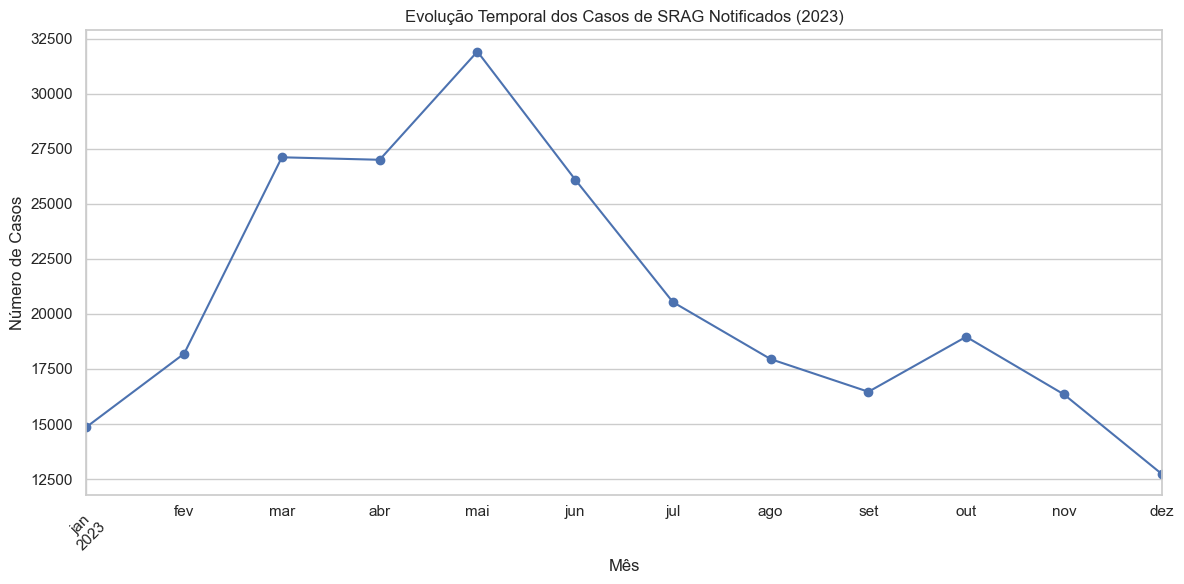

In [1390]:
# Garantir que a coluna está em datetime
dados_filtrados['DT_NOTIFIC'] = pd.to_datetime(dados_filtrados['DT_NOTIFIC'], errors='coerce')

# Filtrar apenas o ano de 2023
dados_2023 = dados_filtrados[dados_filtrados['DT_NOTIFIC'].dt.year == 2023]

# Casos por mês
casos_por_mes = dados_2023['DT_NOTIFIC'].dt.to_period('M').value_counts().sort_index()
casos_por_mes.index = casos_por_mes.index.to_timestamp()

# Plot
plt.figure(figsize=(12, 6))
casos_por_mes.plot(marker='o')
plt.title("Evolução Temporal dos Casos de SRAG Notificados (2023)")
plt.xlabel("Mês")
plt.ylabel("Número de Casos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Ao observar a evolução temporal dos casos de SRAG notificados ao longo do ano de 2023, é possível identificar uma clara sazonalidade. O número de notificações apresenta uma tendência de alta nos primeiros meses do ano, atingindo um pico no mês de maio. A partir desse ponto, os casos começam a diminuir progressivamente até setembro, com uma leve retomada em outubro, seguida por nova queda nos dois últimos meses do ano.

Esse padrão é compatível com o comportamento sazonal de infecções respiratórias, que tendem a se intensificar nos meses mais úmidos e frios, especialmente no outono e inverno. A elevação significativa entre março e maio reforça a importância de estratégias de prevenção nesse período, como campanhas de vacinação e reforço nos protocolos de vigilância.

A leve alta observada em outubro também merece atenção, pois pode indicar uma segunda onda menor ou variações regionais/climáticas que impactam na notificação.

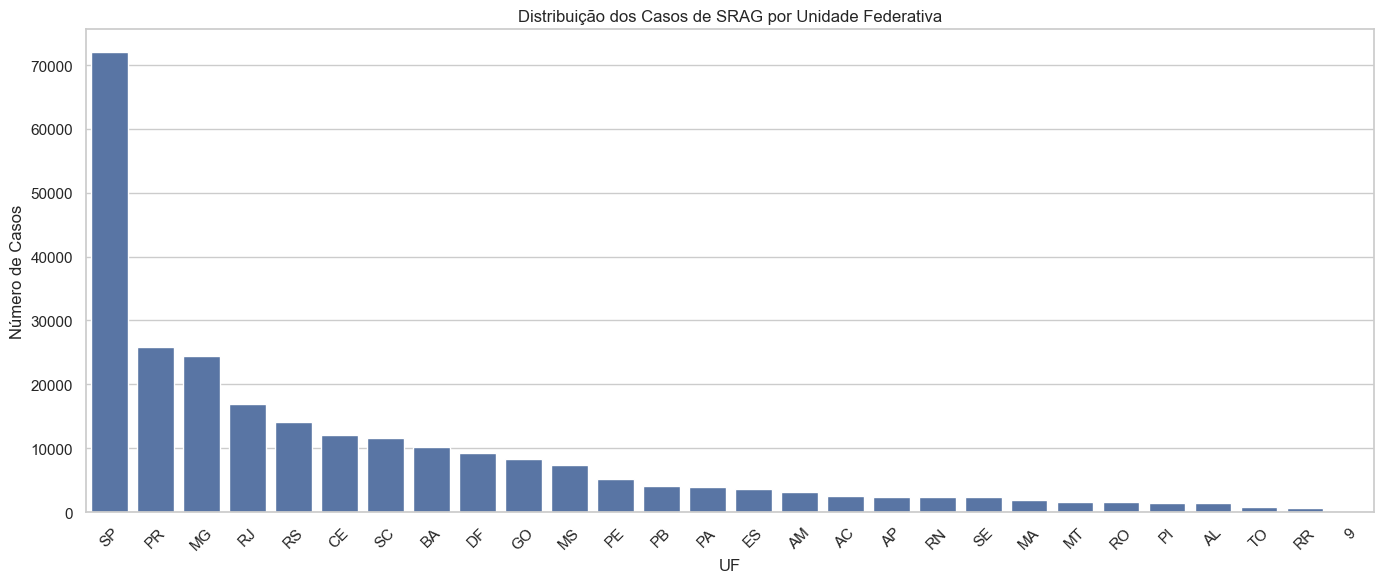

In [1391]:
plt.figure(figsize=(14, 6))
sns.countplot(data=dados_filtrados, x='SG_UF', order=dados_filtrados['SG_UF'].value_counts().index)
plt.title("Distribuição dos Casos de SRAG por Unidade Federativa")
plt.xlabel("UF")
plt.ylabel("Número de Casos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


A distribuição dos casos de SRAG por estado revela uma forte concentração em alguns centros populacionais do país. O estado de São Paulo (SP) lidera com ampla margem, representando sozinho uma fração significativa das notificações. Em seguida, aparecem Paraná (PR), Minas Gerais (MG) e Rio de Janeiro (RJ), todos com volume expressivo de registros.

Essa concentração pode ser explicada por uma combinação de fatores: maior densidade populacional, maior capacidade de testagem e vigilância, além de redes hospitalares mais estruturadas, que favorecem a notificação completa dos casos.

Estados com menor número de notificações não devem ser interpretados como menos afetados, necessariamente. É possível que haja subnotificação devido a limitações de acesso ao sistema de saúde, capacidade laboratorial ou barreiras regionais à vigilância ativa.

Essa análise geográfica reforça a importância de regionalizar estratégias de prevenção, priorizando ações mais intensivas nos estados com maior volume de casos e, ao mesmo tempo, fortalecer a vigilância em regiões historicamente menos estruturadas para que haja equidade na resposta em saúde pública.

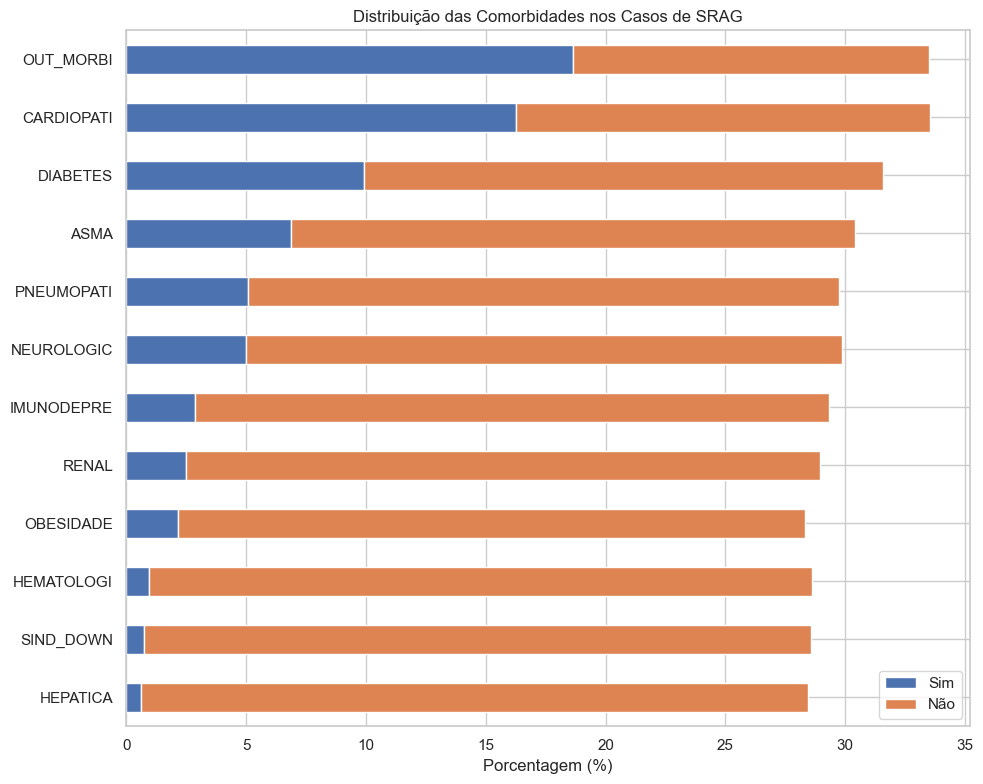

In [1392]:
comorbidades = [
    'CARDIOPATI', 'HEMATOLOGI', 'SIND_DOWN', 'HEPATICA', 'ASMA',
    'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE',
    'RENAL', 'OBESIDADE', 'OUT_MORBI'
]

dados_filtrados_analise = dados_filtrados.copy()

# Converter para object antes de substituir
dados_filtrados_analise[comorbidades] = dados_filtrados_analise[comorbidades].astype("object")

# Agora pode fazer o replace sem erro
dados_filtrados_analise[comorbidades] = dados_filtrados_analise[comorbidades].replace({
    1: 'Sim',
    2: 'Não',
    9: 'Ignorado'
})


comorb_count = {}
for col in comorbidades:
    comorb_count[col] = dados_filtrados_analise[col].value_counts(normalize=True) * 100

# Exibir como gráfico
comorb_df = pd.DataFrame(comorb_count).T[['Sim', 'Não']].fillna(0)
comorb_df.sort_values("Sim", ascending=True).plot(kind="barh", figsize=(10, 8), stacked=True)
plt.title("Distribuição das Comorbidades nos Casos de SRAG")
plt.xlabel("Porcentagem (%)")
plt.tight_layout()
plt.show()


A análise das comorbidades entre os casos de SRAG revela que a presença de condições pré-existentes é bastante comum, embora varie bastante entre os tipos de comorbidade. As categorias com maior prevalência entre os casos são "Outras Morbidades", "Cardiopatia" e "Diabetes". Essas três condições representam as comorbidades mais frequentemente relatadas, e refletem o perfil típico de vulnerabilidade frente a doenças respiratórias graves.

Outras comorbidades como asma, pneumopatias crônicas e distúrbios neurológicos também aparecem em proporções relevantes, reforçando a necessidade de atenção especial a esses grupos.

Já condições como hepatopatias, síndrome de Down e doenças hematológicas aparecem com menor frequência, o que pode indicar uma menor incidência ou uma subnotificação desses fatores nos sistemas de informação.

É importante ressaltar que a presença de múltiplas comorbidades em um mesmo paciente não está capturada nesse gráfico, mas representa um fator de risco ainda maior para agravamento e óbito. Essa análise serve como base para identificar grupos de maior risco, que devem ser priorizados em estratégias de prevenção, atendimento precoce e vacinação.

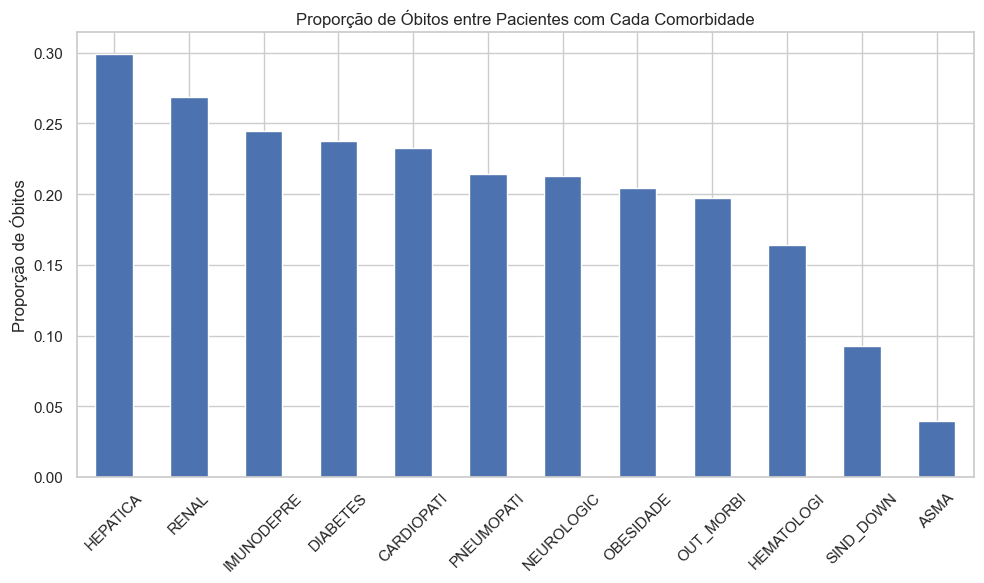

In [1393]:
dados_filtrados_analise["EVOLUCAO_BIN"] = dados_filtrados_analise["EVOLUCAO"].map({1: 0, 2: 1})
# Proporção de óbitos por comorbidade
comorb_mortalidade = {}
for col in comorbidades:
    subset = dados_filtrados_analise[dados_filtrados_analise[col] == 'Sim']
    taxa_obito = subset['EVOLUCAO_BIN'].mean()  # média = proporção de óbitos
    comorb_mortalidade[col] = taxa_obito

comorb_mortalidade = pd.Series(comorb_mortalidade).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
comorb_mortalidade.plot(kind='bar')
plt.title("Proporção de Óbitos entre Pacientes com Cada Comorbidade")
plt.ylabel("Proporção de Óbitos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Este gráfico traz uma perspectiva mais crítica ao mostrar a letalidade associada a cada comorbidade nos casos de SRAG. Ao contrário do gráfico anterior, que mostra apenas a presença das condições, aqui observamos quais comorbidades estão mais associadas ao desfecho de óbito.

Hepatopatias lideram com a maior proporção de óbitos entre os pacientes que as apresentam, seguidas de perto por doenças renais e imunodeficiências. Isso sugere que, embora essas condições sejam menos prevalentes na amostra geral, elas representam um risco significativamente maior de mortalidade quando presentes.

Comorbidades mais comuns como diabetes, cardiopatia e pneumopatias também aparecem com alta taxa de letalidade, reforçando seu papel como fatores de risco críticos para desfechos graves.

Por outro lado, condições como asma, síndrome de Down e doenças hematológicas, apesar de estarem presentes em alguns casos, estão associadas a taxas de óbito relativamente mais baixas, o que pode indicar menor risco ou melhor manejo clínico desses pacientes em contextos de SRAG.

Essas informações são essenciais para priorização clínica: pacientes com hepatopatias, doença renal crônica, imunossupressão e doenças metabólicas devem ser monitorados com maior rigor desde os primeiros sintomas. Além disso, esses achados podem orientar campanhas específicas de vacinação, ações preventivas e protocolos hospitalares diferenciados para grupos de maior risco.

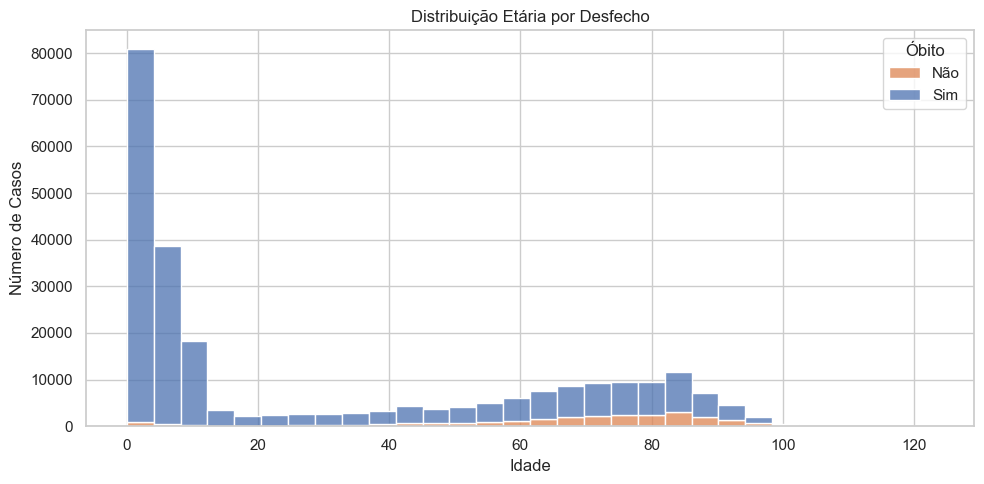

In [1394]:
# Comparação entre óbitos e não óbitos
plt.figure(figsize=(10, 5))
sns.histplot(data=dados_filtrados_analise, x='NU_IDADE_N', hue='EVOLUCAO_BIN', bins=30, kde=False, multiple="stack")
plt.title('Distribuição Etária por Desfecho')
plt.xlabel('Idade')
plt.ylabel('Número de Casos')
plt.legend(title='Óbito', labels=['Não', 'Sim'])
plt.tight_layout()
plt.show()


A análise da distribuição etária por desfecho mostra um padrão claro e esperado: os óbitos por SRAG estão fortemente concentrados nas faixas etárias mais elevadas. O volume de casos em geral é muito alto em crianças de 0 a 5 anos, mas com predomínio de evolução não fatal. Já entre adultos e idosos, especialmente a partir dos 60 anos, observa-se uma inversão: a quantidade de óbitos passa a superar a de sobreviventes.

Essa diferença de perfil etário é fundamental para políticas de prevenção. Enquanto crianças são frequentemente internadas por SRAG, os idosos são os que mais evoluem para óbito, mesmo com menor número absoluto de internações.

Isso reforça a importância de estratégias específicas por faixa etária: vigilância ativa e ampliação de testagem em crianças; priorização de vacinação, atendimento precoce e protocolos intensivos para idosos e portadores de comorbidades.

C:\Users\luisf\AppData\Local\Temp\ipykernel_9672\4223826105.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proporcao_obitos = dados_filtrados_analise.groupby('faixa_etaria')['EVOLUCAO_BIN'].mean()


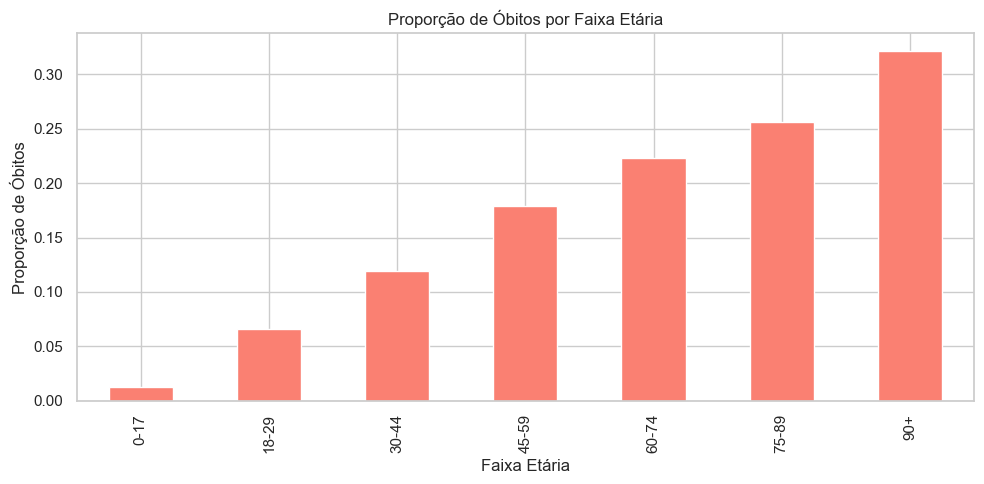

In [1395]:
# Criar faixas etárias
bins = [0, 18, 30, 45, 60, 75, 90, 150]
labels = ['0-17', '18-29', '30-44', '45-59', '60-74', '75-89', '90+']
dados_filtrados_analise['faixa_etaria'] = pd.cut(dados_filtrados_analise['NU_IDADE_N'], bins=bins, labels=labels, right=False)

# Proporção de óbitos por faixa
proporcao_obitos = dados_filtrados_analise.groupby('faixa_etaria')['EVOLUCAO_BIN'].mean()

# Plot
plt.figure(figsize=(10, 5))
proporcao_obitos.plot(kind='bar', color='salmon')
plt.title('Proporção de Óbitos por Faixa Etária')
plt.ylabel('Proporção de Óbitos')
plt.xlabel('Faixa Etária')
plt.tight_layout()
plt.show()


A curva de letalidade por faixa etária revela uma relação clara e crescente entre idade e risco de morte por SRAG. A taxa de óbito é muito baixa em indivíduos com até 17 anos, mas aumenta de forma progressiva a partir dos 30 anos, atingindo valores críticos a partir dos 60.

O grupo com maior vulnerabilidade é o de 90 anos ou mais, com uma taxa de óbito superior a 30% dos casos registrados. Essa escalada de risco reforça a idade como um dos fatores preditores mais relevantes para a evolução desfavorável em casos de SRAG.

Essas evidências corroboram a necessidade de priorização dos idosos em políticas de prevenção, vigilância e tratamento precoce. O gráfico também reforça que, embora comorbidades sejam relevantes, a idade por si só já representa um risco elevado que precisa ser monitorado de forma ativa.

C:\Users\luisf\AppData\Local\Temp\ipykernel_9672\4165944106.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comorb_bin = dados_filtrados_analise[comorbidades].replace({


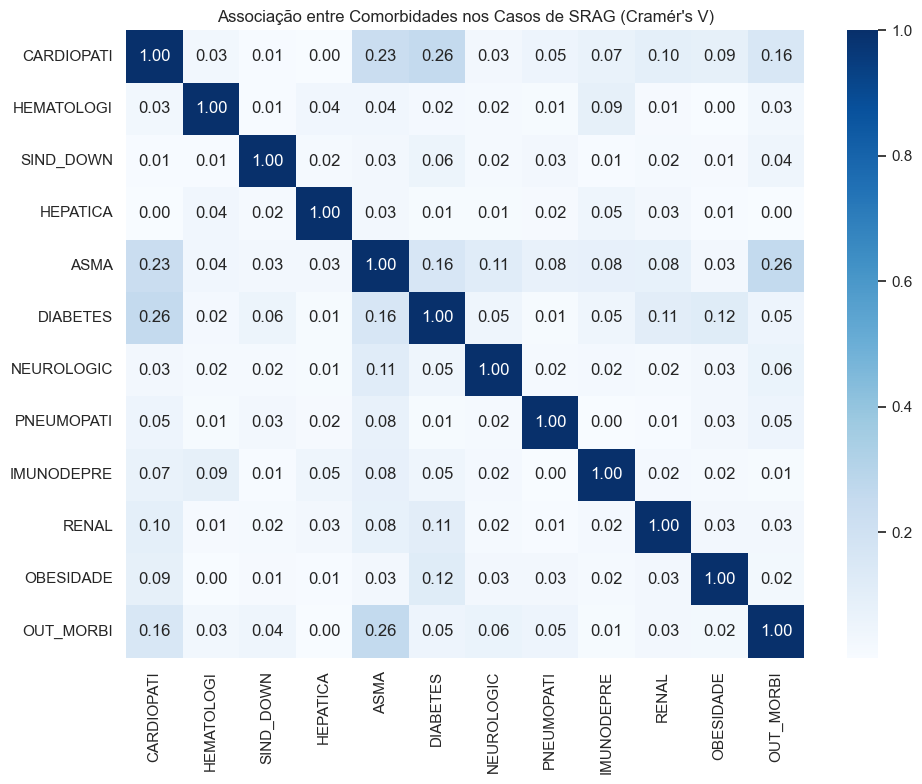

In [1396]:
# Lista de comorbidades
comorbidades = [
    'CARDIOPATI', 'HEMATOLOGI', 'SIND_DOWN', 'HEPATICA', 'ASMA',
    'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE',
    'RENAL', 'OBESIDADE', 'OUT_MORBI'
]

# Substituir 'Sim', 'Não', 'Ignorado' por 1, 0, NaN
comorb_bin = dados_filtrados_analise[comorbidades].replace({
    'Sim': 1,
    'Não': 0,
    'Ignorado': np.nan
})

# Remover linhas com valores ausentes
comorb_bin = comorb_bin.dropna()

# Função de Cramér’s V
def cramers_v(x, y):
    tabela = pd.crosstab(x, y)
    chi2 = chi2_contingency(tabela, correction=False)[0]
    n = tabela.sum().sum()
    phi2 = chi2 / n
    r, k = tabela.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# Criar matriz
cramers_matrix = pd.DataFrame(np.zeros((len(comorb_bin.columns), len(comorb_bin.columns))),
                              columns=comorb_bin.columns, index=comorb_bin.columns)

for col1 in comorb_bin.columns:
    for col2 in comorb_bin.columns:
        cramers_matrix.loc[col1, col2] = cramers_v(comorb_bin[col1], comorb_bin[col2])

# Plot do heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title("Associação entre Comorbidades nos Casos de SRAG (Cramér's V)")
plt.tight_layout()
plt.show()



Associação entre Comorbidades nos Casos de SRAG (Cramér’s V)
Utilizando o coeficiente de Cramér’s V, mais apropriado para variáveis binárias, foi possível avaliar a associação entre comorbidades de forma mais robusta. Ainda que a maioria das correlações se mantenha fraca, alguns padrões relevantes se destacam.

As associações mais fortes observadas foram entre:

Diabetes e Cardiopatia (V = 0.26)

Asma e Outras Morbidades (V = 0.26)

Cardiopatia e Asma (V = 0.23)

Essas combinações refletem agrupamentos clínicos plausíveis, especialmente entre condições metabólicas (diabetes e cardiopatias) e perfis respiratórios. Ainda que os coeficientes estejam abaixo de 0.3 — o que indica associação moderada — eles apontam para a presença de subgrupos de pacientes com perfis mais complexos, o que pode ser relevante para protocolos de triagem e manejo hospitalar.

Por outro lado, diversas comorbidades seguem apresentando baixa associação entre si, sugerindo que elas ocorrem de forma relativamente independente na base, ou que há possível subnotificação ou ausência de vínculos diretos entre essas condições no contexto da SRAG.


## Modelos de Machine Learning:

Preparação dos dados:

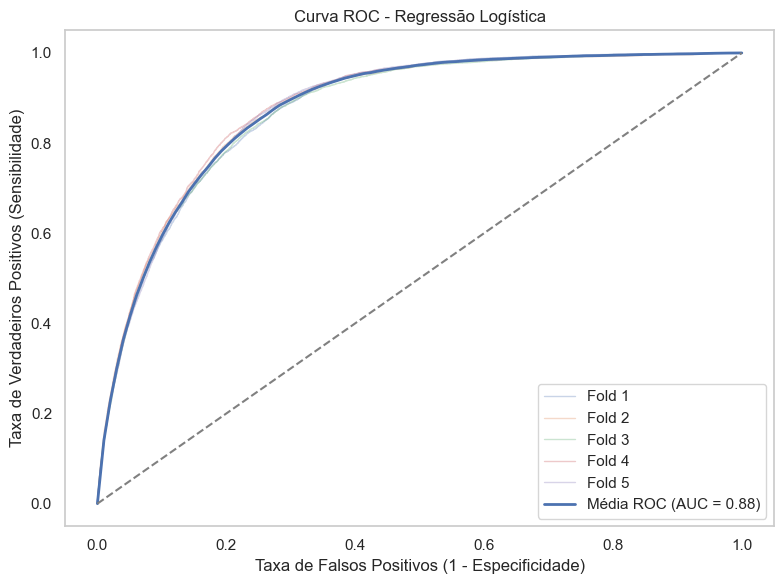

=== Métricas Médias da Validação Cruzada (5-Fold) ===
Acurácia: 0.779
Precisão: 0.288
Recall (Sensibilidade): 0.826
F1-score: 0.427
AUC: 0.878

Exemplo de matriz de confusão no último fold:
[[35034 10206]
 [  823  4097]]
Sensibilidade (Recall): 0.833
Especificidade: 0.774


In [1397]:
# Preparo dos dados
dados_filtrados["EVOLUCAO_BIN"] = dados_filtrados["EVOLUCAO"].map({1: 0, 2: 1})
dados_filtrados = dados_filtrados[dados_filtrados['CS_SEXO'] != 'I']
dados_filtrados['CS_SEXO'] = dados_filtrados['CS_SEXO'].map({'M': 1, 'F': 0}).astype('Int64')

drop_cols = ['DT_NOTIFIC', 'DT_SIN_PRI', 'EVOLUCAO']
X = dados_filtrados.drop(columns=drop_cols + ['EVOLUCAO_BIN'])
y = dados_filtrados['EVOLUCAO_BIN']

categorical_cols = X.select_dtypes(include="object").columns.tolist()
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Inicializar KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Listas para métricas
accs, precisions, recalls, f1s, aucs = [], [], [], [], []
tprs, mean_fpr = [], np.linspace(0, 1, 100)

plt.figure(figsize=(8, 6))

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):
    X_train_raw, X_test_raw = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Preprocessamento + SMOTE
    X_train_proc = preprocessor.fit_transform(X_train_raw)
    X_test_proc = preprocessor.transform(X_test_raw)

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train_proc, y_train)

    model = LogisticRegression(max_iter=1000)
    model.fit(X_resampled, y_resampled)

    y_pred = model.predict(X_test_proc)
    y_prob = model.predict_proba(X_test_proc)[:, 1]

    accs.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    aucs.append(roc_auc_score(y_test, y_prob))

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f"Fold {fold}")

# Curva ROC média
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(aucs)

plt.plot(mean_fpr, mean_tpr, color='b', label=f'Média ROC (AUC = {mean_auc:.2f})', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Taxa de Falsos Positivos (1 - Especificidade)")
plt.ylabel("Taxa de Verdadeiros Positivos (Sensibilidade)")
plt.title("Curva ROC - Regressão Logística")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Exibir médias das métricas
print("=== Métricas Médias da Validação Cruzada (5-Fold) ===")
print(f"Acurácia: {np.mean(accs):.3f}")
print(f"Precisão: {np.mean(precisions):.3f}")
print(f"Recall (Sensibilidade): {np.mean(recalls):.3f}")
print(f"F1-score: {np.mean(f1s):.3f}")
print(f"AUC: {np.mean(aucs):.3f}")

# Matriz de confusão final em um dos folds (opcional)
print("\nExemplo de matriz de confusão no último fold:")
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print(cm)
print(f"Sensibilidade (Recall): {tp / (tp + fn):.3f}")
print(f"Especificidade: {tn / (tn + fp):.3f}")


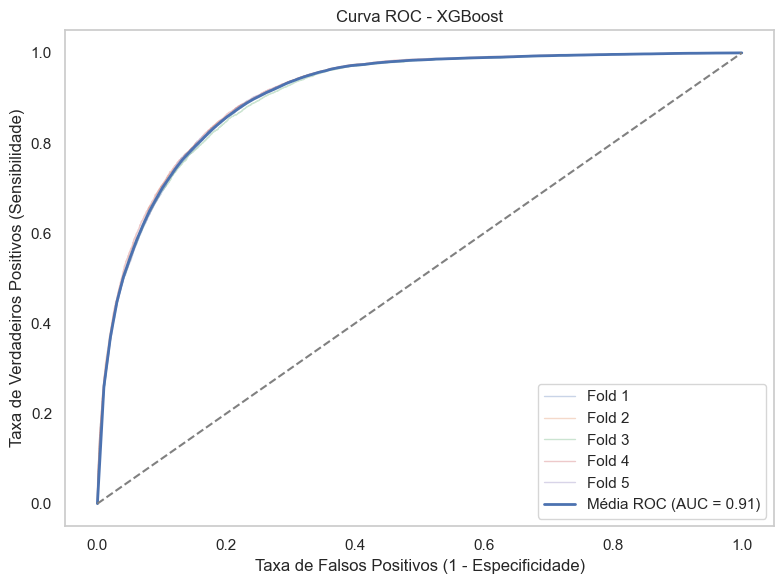

=== Métricas Médias da Validação Cruzada (5-Fold) ===
Acurácia: 0.919
Precisão: 0.647
Recall (Sensibilidade): 0.411
F1-score: 0.502
AUC: 0.910

Exemplo de matriz de confusão no último fold:
[[44038  1202]
 [ 2889  2031]]
Sensibilidade (Recall): 0.413
Especificidade: 0.973


In [1398]:
# Variável alvo binária
dados_filtrados["EVOLUCAO_BIN"] = dados_filtrados["EVOLUCAO"].map({1: 0, 2: 1})

# Seleção das colunas
cols = [
    'CARDIOPATI', 'HEMATOLOGI', 'SIND_DOWN', 'HEPATICA', 'ASMA',
    'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE',
    'RENAL', 'OBESIDADE', 'OUT_MORBI', 'CS_SEXO', 'NU_IDADE_N', 
    'CS_ESCOL_N', 'CS_ZONA', 'NOSOCOMIAL', 'AVE_SUINO',
    'FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'SATURACAO',
    'DIARREIA', 'VOMITO', 'OUTRO_SIN', 'PUERPERA', 'FATOR_RISC',
    'TRAT_COV', 'ANTIVIRAL', 'HOSPITAL', 'UTI', 'SUPORT_VEN', 'VACINA', 
    'DOR_ABD', 'FADIGA', 'PERD_OLFT', 'PERD_PALA',
    'TOMO_RES', 'RES_AN', 'VACINA_COV', 'FNT_IN_COV', 'REINF', 
    'FOI_INTERNADO', 'ENTROU_UTI'
]
X = dados_filtrados[cols]
y = dados_filtrados['EVOLUCAO_BIN']

# Padronização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Métricas
accs, precisions, recalls, f1s, aucs = [], [], [], [], []
tprs, mean_fpr = [], np.linspace(0, 1, 100)

plt.figure(figsize=(8, 6))

for fold, (train_idx, test_idx) in enumerate(kf.split(X_scaled, y), 1):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Aplicar SMOTE no treino
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0)
    model.fit(X_resampled, y_resampled)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    accs.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    aucs.append(roc_auc_score(y_test, y_prob))

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f"Fold {fold}")

# Curva ROC média
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(aucs)

plt.plot(mean_fpr, mean_tpr, color='b', label=f'Média ROC (AUC = {mean_auc:.2f})', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Taxa de Falsos Positivos (1 - Especificidade)")
plt.ylabel("Taxa de Verdadeiros Positivos (Sensibilidade)")
plt.title("Curva ROC - XGBoost")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Resultados médios
print("=== Métricas Médias da Validação Cruzada (5-Fold) ===")
print(f"Acurácia: {np.mean(accs):.3f}")
print(f"Precisão: {np.mean(precisions):.3f}")
print(f"Recall (Sensibilidade): {np.mean(recalls):.3f}")
print(f"F1-score: {np.mean(f1s):.3f}")
print(f"AUC: {np.mean(aucs):.3f}")

# Exemplo de matriz de confusão do último fold
print("\nExemplo de matriz de confusão no último fold:")
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print(cm)
print(f"Sensibilidade (Recall): {tp / (tp + fn):.3f}")
print(f"Especificidade: {tn / (tn + fp):.3f}")



# Análise Comparativa: Regressão Logística vs. XGBoost

## Desempenho Geral dos Modelos

Os dois modelos testados — Regressão Logística e XGBoost — apresentaram bons desempenhos, mas com focos distintos. O XGBoost teve melhor desempenho geral nas métricas de acurácia, precisão, F1-score e AUC, o que indica que ele conseguiu um melhor equilíbrio entre classes e acertos totais. No entanto, a Regressão Logística se destacou fortemente na sensibilidade (recall), identificando uma proporção muito maior dos casos positivos (óbitos).

Isso sugere que, enquanto o XGBoost teve um desempenho mais robusto e conservador, a Regressão Logística foi mais agressiva na detecção de óbitos, mesmo ao custo de maior número de falsos positivos.

## Interpretação das Métricas

A Regressão Logística apresentou uma acurácia média de 0.779 e um AUC de 0.878, com sensibilidade de 0.826 e especificidade de 0.774. Já o XGBoost apresentou acurácia média de 0.919 e AUC de 0.910, mas com recall consideravelmente menor (0.411), embora com alta especificidade (0.973).

Esses resultados evidenciam que o XGBoost tem um viés maior para reduzir falsos positivos (alto controle sobre o erro tipo I), enquanto a Regressão Logística tende a reduzir falsos negativos (erro tipo II), o que pode ser crucial em contextos sensíveis como o de prever óbitos.

## Considerações sobre o Pré-processamento

No caso da Regressão Logística, foi necessário realizar pré-processamento mais elaborado, incluindo transformação de variáveis categóricas via OneHotEncoder e padronização de variáveis numéricas. Já o XGBoost foi aplicado sobre dados numéricos padronizados, mas sem a necessidade de encoding de variáveis categóricas, pois apenas variáveis numéricas foram utilizadas.

Esse ponto destaca uma vantagem prática do XGBoost em fluxos com menos tratamento categórico, embora isso também tenha limitado o volume de informação processada quando comparado à abordagem da Regressão Logística.

## Papel do SMOTE

O uso do SMOTE em ambos os modelos foi fundamental para balancear as classes antes do treinamento. Como a base original era desbalanceada (com muito mais casos de não-óbito), o SMOTE ajudou os modelos a aprenderem representações mais equilibradas.

Contudo, é importante ressaltar que o SMOTE foi aplicado **somente nos dados de treino dentro de cada fold da validação cruzada**, evitando vazamento de informação e garantindo uma avaliação honesta. Mesmo assim, o uso do SMOTE pode gerar exemplos sintéticos que aumentam o risco de overfitting, principalmente em modelos mais complexos como o XGBoost.

## Transparência e Interpretabilidade

A Regressão Logística tem vantagem clara em interpretabilidade. Cada coeficiente do modelo pode ser diretamente interpretado como a influência (positiva ou negativa) de uma variável na chance de óbito. Isso é especialmente importante em áreas como saúde pública, onde a explicabilidade do modelo pode ter tanto peso quanto sua acurácia.

O XGBoost, por outro lado, é mais opaco. Embora existam ferramentas como SHAP para análise de importância de features, o modelo em si não oferece uma explicação direta de suas decisões. Por isso, em contextos em que a transparência é essencial, a Regressão Logística pode ser preferida, mesmo com desempenho ligeiramente inferior.



Portanto, ambos os modelos são válidos e apresentam pontos fortes distintos. O XGBoost tem desempenho global superior e é indicado quando o objetivo é maximizar acerto geral com baixo erro tipo I. A Regressão Logística é mais transparente e sensível, sendo mais adequada quando o foco está em capturar todos os possíveis casos positivos, mesmo ao custo de mais falsos positivos.

A escolha entre os dois modelos depende, portanto, dos objetivos específicos da aplicação: controle rigoroso de erros ou sensibilidade e interpretabilidade.



# Conclusão e Recomendações

## Conclusão

A análise da base de dados de SRAG 2023 permitiu identificar padrões relevantes associados à evolução dos casos hospitalizados. O processo de limpeza e tratamento da base foi essencial para garantir a qualidade dos dados, removendo colunas com alta taxa de nulos e mantendo apenas registros com desfecho claramente definido (óbito ou não óbito).

A aplicação de modelos de machine learning mostrou que tanto a Regressão Logística quanto o XGBoost foram eficazes em identificar os casos positivos (óbitos), com o XGBoost apresentando desempenho geral superior em métricas como acurácia, precisão, F1-score e AUC. Contudo, a Regressão Logística demonstrou maior sensibilidade, sendo mais eficaz na identificação de óbitos, embora com menor precisão.

O uso do SMOTE foi essencial para equilibrar as classes, considerando a proporção inicial desbalanceada entre óbitos e não óbitos. Ao ser aplicado apenas sobre os dados de treino em cada fold da validação cruzada, foi possível evitar vazamento de informação e garantir uma avaliação mais fiel do desempenho dos modelos.

## Recomendações

1. **Monitoramento de Grupos de Risco**: Com base nas variáveis mais influentes nos modelos (como idade, comorbidades e uso de suporte ventilatório), recomenda-se um acompanhamento mais próximo dos pacientes que apresentam essas características no momento da notificação.

2. **Capacitação para Profissionais de Saúde**: A interpretação dos modelos pode ser utilizada para treinar equipes médicas e de vigilância sobre os principais fatores de risco associados a desfechos graves, contribuindo para decisões mais rápidas e eficazes.

3. **Investimentos em Dados e Sistemas**: A qualidade do dado inicial impacta diretamente os modelos preditivos. Melhorar os sistemas de notificação e preenchimento de campos importantes pode aumentar ainda mais o poder preditivo de modelos futuros.

4. **Uso Integrado de Modelos**: Em ambientes críticos como saúde pública, a combinação entre modelos mais sensíveis (como Regressão Logística) e mais específicos (como o XGBoost) pode ser útil para estratégias distintas, como triagem inicial e confirmação de risco.

5. **Atualização Contínua do Modelo**: Dado o caráter sazonal e mutável das síndromes respiratórias, é recomendável que os modelos sejam recalibrados periodicamente com dados mais recentes, incorporando possíveis mudanças no perfil clínico e nos desfechos dos pacientes.

Essas recomendações podem servir de base para políticas públicas mais direcionadas à prevenção e à mitigação de óbitos por SRAG, utilizando a ciência de dados como apoio estratégico na tomada de decisão.
